In [4]:
import pandas as pd
import math
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from MEBF import MEBF, matrix_subtract, matrix_product
import seaborn as sns
import time
from scipy import stats
%matplotlib inline

In [87]:
data = pd.read_csv("gene.csv",index_col = 0)

Text(0, 0.5, 'explained variance ratio(%)')

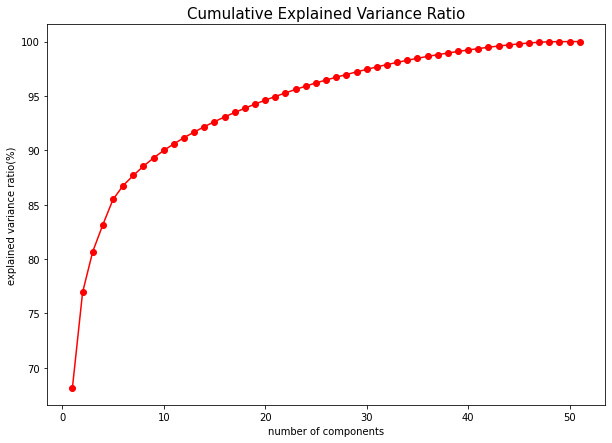

In [88]:
from sklearn.preprocessing import scale
data_norm = scale(data)
pca = PCA(n_components = 'mle')
pca.fit(data_norm)
evr = pca.explained_variance_ratio_ * 100
# 查看累计解释方差比率与主成分个数的关系
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.arange(1, len(evr) + 1), np.cumsum(evr), "-ro")
ax.set_title("Cumulative Explained Variance Ratio", fontsize=15)
ax.set_xlabel("number of components")
ax.set_ylabel("explained variance ratio(%)")

In [91]:
data_norm = scale(data)
pca = PCA(n_components = 2)
pca.fit(data_norm)
pca_df = pca.transform(data_norm)
df_approx = np.dot(pca_df,pca.components_)

In [92]:
data_res = pd.DataFrame(data=(data_norm-df_approx),index = data.index, columns = data.columns)

In [93]:
data_res.head(3)

,CY58_1_CD45_F08_S1028_comb,CY58_1_CD45_A05_S965_comb,CY58_1_CD45_D01_S997_comb,cy80.Cd45.pos.Pd1.neg.S293.E05.S293.comb,cy82.CD45.pos.3.A07.S7.comb,cy82.CD45.pos.3.B08.S20.comb,cy53.1.CD45.pos.2.A04.S964.comb,cy53.1.CD45.pos.1.D01.S37.comb,cy53.1.CD45.pos.2.B08.S980.comb,cy53.1.CD45.pos.1.F04.S64.comb,...,cy60_1_cd_45_pos_3_C04_S316_comb,CY89FNA_A03_S195_comb,CY88CD45POS_2_F07_S451_comb,CY88CD45_150813_D05_S329_comb,CY88CD45POS_2_G06_S462_comb,CY94CD45POS_1_E04_S148_comb,CY88CD45POS_2_F09_S453_comb,CY84_PRIM_POS_All_7_E07_S247_comb,CY84_PRIM_POS_All_7_B06_S210_comb,CY84_PRIM_POS_All_8_E10_S154_comb
C9orf152,-0.027983,-0.000077,0.013047,-0.009702,0.008234,-0.004529,0.003791,0.021651,0.014998,0.005545,...,-0.014811,0.018678,-0.004977,-0.011390,-0.000586,-0.001243,0.008308,0.006959,-0.002875,0.006738
RPS11,3.159347,0.723635,-5.744062,-0.127852,-3.724122,0.571575,1.233293,-3.903115,10.197677,0.842962,...,-2.600212,-3.429630,1.639268,2.123435,3.793954,2.905514,-3.235641,-4.727140,-1.430623,-0.887820
ELMO2,1.265299,-0.076449,-0.051519,-0.102913,-0.090365,0.053735,-0.088358,-0.066446,0.051392,-0.088679,...,-0.083110,-0.075638,1.423685,-0.107637,-0.092302,-0.100138,-0.094945,-0.089345,0.874676,-0.091467


# Boolean Matrix Factorization

In [9]:
x_in_paper = pd.DataFrame(np.array([[1,1,0,1,1,1,0,1,0,0,0],[1,1,1,1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,0,1,0,1],
         [0,1,0,0,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,0,0],[1,1,1,1,1,1,1,0,1,0,0],
         [0,0,0,1,0,0,0,0,0,0,0],[1,1,1,1,1,1,1,1,1,1,0],[1,1,0,1,0,1,1,0,0,0,0],
         [1,1,1,1,1,0,0,0,0,0,0,],[1,1,0,1,1,0,0,0,0,0,0]]), index = range(1,12), columns = range(1,12))
A,B = MEBF(x_in_paper,0.8)

<AxesSubplot:>

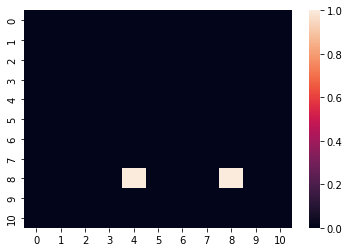

In [10]:
sns.heatmap(matrix_subtract(x_in_paper.values, matrix_product(A.values, B.values)), annot=False, vmin=0, vmax=1)

# BCV

### set iteration = 30

In [149]:
# drop rows and cols with all 0s, used in my_pca
no_pre = data.copy()
no_pre = no_pre.loc[(no_pre!=0).any(axis=1)]
no_pre = no_pre.loc[:,(no_pre!= 0).any(axis=0)]

In [150]:
def my_pca(data,times=1, num_comps=20):
    x = pd.DataFrame(scale(data),index = data.index, columns = data.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        pca = PCA(n_components = num)
        pca.fit(x.values)
        pca_df = pca.transform(x)
        x_approx = np.dot(pca_df,pca.components_)
        residule = x.values-x_approx
        error.loc[1][num] = sum(np.abs(residule)).sum()
    return error

In [210]:
def bcv(data,times=20, num_comps=20, left_1=5, left_2=5):
    # times = 15
    # num_comps = 25
    x = pd.DataFrame(scale(data),index = data.index, columns = data.columns)
    error = pd.DataFrame(index = range(1,times+1), columns = range(1,num_comps+1))
    # iterate over number of components
    for num in range(1,num_comps+1):
        for time in range(1,times+1):
            # shuffle x
            x = x[np.random.permutation(x.columns)]
            x = x.reindex(np.random.permutation(x.index))
            # leave out submatrix
            A = x.values[:left_1,:left_2]
            B = x.values[:left_1,left_2:]
            C = x.values[left_1:,:left_2]
            D = x.values[left_1:,left_2:]
            # perform PCA
            pca = PCA(n_components = num)
            pca.fit(D)
            pca_df = pca.transform(D)
            D_approx = pca.inverse_transform(pca_df)
            residule = np.dot( np.dot(B,np.linalg.pinv(D_approx)), C) - A
            error.loc[time][num] = sum(np.abs(residule)).sum()
    return error

In [216]:
def compute_q2(data,error):
    q2 = pd.DataFrame(np.array(np.var(error)).reshape(1,-1),columns = error.columns)
    q2 /= np.matrix(data.values).var()
    return 1-q2

## Personally, I prefer 5%

In [204]:
# preprocess on data
# first, drop rows and cols with all 0s
pre = data.copy()
pre = pre.loc[(pre!=0).any(axis=1)]
pre = pre.loc[:,(pre!= 0).any(axis=0)]

In [205]:
times = 30
num_comps = 20
error_t = bcv(pre,times,num_comps,round(pre.shape[0]*0.05),round(pre.shape[1]*0.05))
q2 = compute_q2(pre,error_t)
#candidate = []
for i in range(1,num_comps):
    print("Huge difference between ",i, i+1, 
          (stats.ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue <= 0.1))
    #if ((stats.ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue <= 0.1)):
        #candidate.append(i+1)

Huge difference between  1 2 True
Huge difference between  2 3 False
Huge difference between  3 4 False
Huge difference between  4 5 False
Huge difference between  5 6 False
Huge difference between  6 7 False
Huge difference between  7 8 False
Huge difference between  8 9 False
Huge difference between  9 10 False
Huge difference between  10 11 False
Huge difference between  11 12 False
Huge difference between  12 13 False
Huge difference between  13 14 False
Huge difference between  14 15 False
Huge difference between  15 16 False
Huge difference between  16 17 False
Huge difference between  17 18 False
Huge difference between  18 19 False
Huge difference between  19 20 False


In [226]:
np.matrix(pre.values).var()

442147.5689915007

In [224]:
np.var(error_t)

1     2266.483562
2     4076.654939
3     4590.063345
4     3122.103934
5     2659.050588
6     2358.880771
7     3001.839142
8     2268.008058
9     2124.288878
10    4654.538956
11    2114.436726
12    2332.584509
13    2533.834676
14    2185.407835
15    3053.839735
16    3620.810288
17    1530.747178
18    4293.123166
19    2027.281065
20    4323.446955
dtype: float64

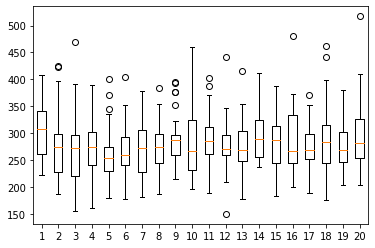

In [206]:
plt.boxplot(error_t);

In [208]:
q2

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.994874,0.99078,0.989619,0.992939,0.993986,0.994665,0.993211,0.99487,0.995196,0.989473,0.995218,0.994724,0.994269,0.995057,0.993093,0.991811,0.996538,0.99029,0.995415,0.990222


<BarContainer object of 20 artists>

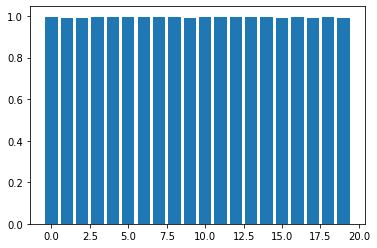

In [207]:
plt.bar(range(q2.shape[1]),list(q2.values.flatten()))

In [186]:
times = 30
num_comps = 20
error_t = bcv(pre,times,num_comps,round(pre.shape[0]*0.05),round(pre.shape[1]*0.05))
q2 = compute_q2(pre,error_t)
#candidate = []
for i in range(1,num_comps):
    print("Huge difference between ",i, i+1, 
          (stats.ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue <= 0.1))
    #if ((stats.ttest_ind(error_t[i],error_t[i+1], equal_var = False).pvalue <= 0.1)):
        #candidate.append(i+1)

Huge difference between  1 2 False
Huge difference between  2 3 False
Huge difference between  3 4 False
Huge difference between  4 5 False
Huge difference between  5 6 False
Huge difference between  6 7 False
Huge difference between  7 8 False
Huge difference between  8 9 False
Huge difference between  9 10 False
Huge difference between  10 11 False
Huge difference between  11 12 False
Huge difference between  12 13 False
Huge difference between  13 14 False
Huge difference between  14 15 False
Huge difference between  15 16 False
Huge difference between  16 17 False
Huge difference between  17 18 False
Huge difference between  18 19 False
Huge difference between  19 20 False


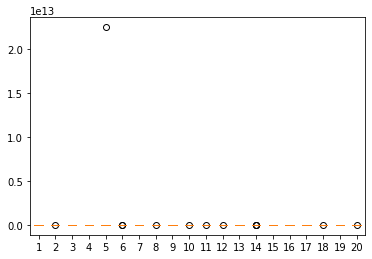

In [187]:
plt.boxplot(error_t);

In [189]:
error_t

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,267.889237,260.152563,250.339313,248.676011,329.730031,358.447614,192.885326,353.488713,296.959993,243.311279,223.459035,269.066608,248.543214,253.462836,259.544737,252.829577,319.730866,457.204749,295.746137,255.410598
2,308.523596,305.121874,309.603731,281.029979,376.2669,323.061539,290.988652,280.112149,268.049289,268.66382,286.236591,295.761324,224.675938,308.615755,350.346442,265.666533,225.232466,290.796178,310.310522,261.062525
3,217.381999,244.947977,278.091029,163.323907,470.961297,306.564853,261.173892,263.178476,221.703095,288.08901,267.643276,169.308995,314.97286,237.020526,265.97621,262.491505,237.157422,338.95158,268.261428,260.167722
4,251.40011,361.341503,207.471991,282.087621,298.9183,209.975283,207.815294,236.080188,227.637044,366.444913,304.569811,240.358392,218.86826,205.561065,294.516144,271.83253,381.153546,294.728036,234.422111,341.084885
5,229.757371,241.804629,273.523317,354.772037,250.828627,321.185038,239.880372,314.124728,250.134199,269.535633,153.995258,255.824173,249.855204,374.070037,166.961466,302.543381,192.828726,330.346917,237.140467,245.381805
6,293.592494,289.65515,206.789812,342.519032,179.878316,296.751547,214.800004,270.138658,236.579407,306.186347,299.681848,292.256238,378.850369,282.438877,317.647362,223.840063,240.613056,281.724108,335.976928,360.935821
7,327.675853,280.382481,294.069328,229.552087,261.160602,299.068599,310.892864,205.017703,226.745883,225.620556,445.36119,312.760441,242.390314,239.444281,219.310373,265.698794,270.484651,272.893692,374.790536,255.088379
8,331.087498,275.963442,237.739084,228.218645,395.39507,289.11418,309.163989,249.174571,239.225431,232.402327,240.410108,210.204787,301.657547,295.88162,357.673142,266.401972,243.794788,316.2422,300.48315,230.60387
9,305.501385,354.024273,230.898908,263.565021,204.145,363.689566,208.23087,289.240984,290.006997,272.514905,275.755744,263.979245,262.191756,207.968326,249.827643,325.420273,194.219892,260.711408,305.988529,189.429051
10,246.430015,232.048402,264.456699,257.110029,394.27081,305.91907,289.391307,217.835166,276.60185,214.580366,232.668104,274.021967,301.285785,273.784189,334.026897,225.639435,287.351776,389.816762,327.120296,243.391214


<BarContainer object of 20 artists>

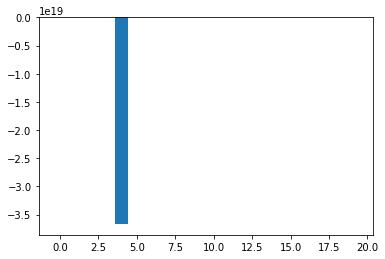

In [188]:
plt.bar(range(q2.shape[1]),list(q2.values.flatten()))

In [ ]:
# 如果默认 92.5% 足够去分辨出feature pattern， 如果对 leave-out 的fit效果不好，是否可以认为剩余部分是noise？